In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

2024-07-30 20:25:03.798730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 20:25:03.798780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 20:25:03.800231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
test_data = '/kaggle/input/english-handwritten-characters-dataset/english.csv'
df = pd.read_csv(test_data)

In [4]:
df["label"].value_counts()


label
0    55
1    55
2    55
3    55
4    55
     ..
v    55
w    55
x    55
y    55
z    55
Name: count, Length: 62, dtype: int64

In [5]:
# labels = df_test_data['label'].tolist()
# labels

In [6]:
images_path = '/kaggle/input/english-handwritten-characters-dataset/Img'

# List to hold the dimensions of all images
image_sizes = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path)
    if image is not None:
        height, width = image.shape[:2]
        image_sizes.append((width, height))

# Print the size of the first image
if image_sizes:
    print("Size of the first image:", image_sizes[1])
    print("Unique image sizes:", set(image_sizes))
else:
    print("No images found in the directory.")

Size of the first image: (1200, 900)
Unique image sizes: {(1200, 900)}


In [7]:
images_path = '/kaggle/input/english-handwritten-characters-dataset/Img'
images = []
labels = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path).astype('float32')
    image = cv.resize(image, (64, 64))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #image = cv.GaussianBlur(image, (1, 1), 0)
    image /= 255.0
    label_index = os.path.join("Img", image_file)
    label = df[df['image'] == label_index].label.values[0]
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)


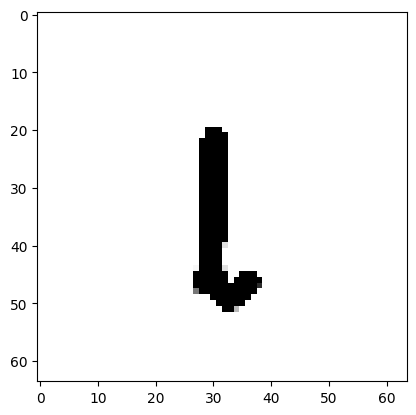

In [8]:
plt.gray()
plt.imshow(images[100])

In [9]:
print("Number of images:", len(images))
print("Shape of each image:", images.shape[1:])
print("Unique labels:", np.unique(labels))

Number of images: 3410
Shape of each image: (64, 64)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [10]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))


In [11]:
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]


In [12]:
images, labels = shuffle(images, labels, random_state=0)


In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define an exponential decay learning rate schedule function
def exponential_decay(epoch, lr):
    initial_lr = 0.001
    k = 0.1
    decay_rate = k ** (epoch / 10)
    return initial_lr * decay_rate

In [14]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range=0.2, 
    shear_range=0.2,               
    fill_mode='nearest'
)

In [16]:
# Initialize lists to hold augmented images and labels
augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

# Iterate over each image in X_train
for i in range(len(X_train)):
    # Ensure the image has the correct shape (height, width, channels)
    image = X_train[i]
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)  # Convert (height, width) to (height, width, channels)
    
    # Expand dimensions to include batch size
    image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)
    
    # Create iterator for augmented images
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    
    # Generate augmented images
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    
    # Extend the list with the new augmented images and corresponding labels
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

# Convert lists to numpy arrays
augmented_arr_X = np.array(augmented_arr_X)
augmented_arr_Y = np.array(augmented_arr_Y)

print("Augmented images shape:", augmented_arr_X.shape)
print("Augmented labels shape:", augmented_arr_Y.shape)

Augmented images shape: (11935, 64, 64, 1)
Augmented labels shape: (11935, 62)


In [17]:
X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [18]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


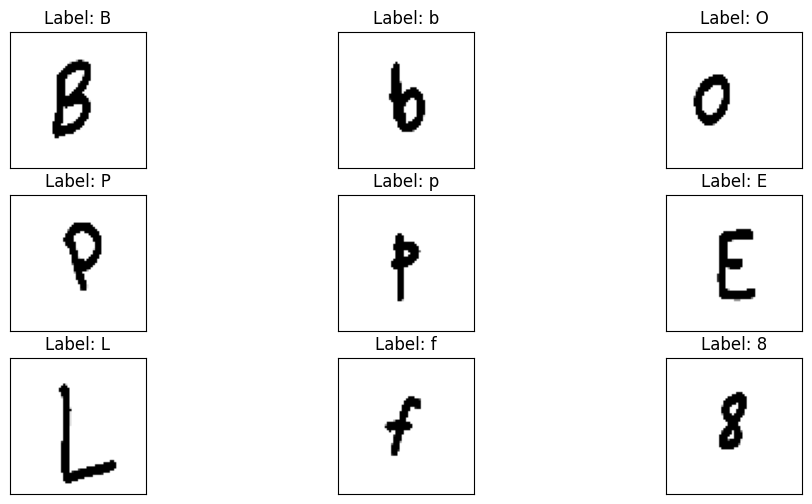

In [19]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

In [20]:
num_classes = len(np.unique(labels))  # Check how many unique labels you have
print("Number of classes:", num_classes)


Number of classes: 2


In [28]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='relu'),
    
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(62, activation='softmax')
])

In [29]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,699,774 (29.37 MB)

 Trainable params: 7,699,774 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (11935, 64, 64, 1)
Shape of X_val: (511, 64, 64)
Shape of X_test: (512, 64, 64)


In [31]:
import tensorflow as tf

from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy

# Create a mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=20, 
    batch_size=32,  
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks here
)


Epoch 1/20
 10/373 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0143 - loss: 4.3406      

W0000 00:00:1722371629.692782     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0177 - loss: 4.1861

W0000 00:00:1722371647.009897     404 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722371647.809085     403 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


373/373 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.0177 - loss: 4.1859 - val_accuracy: 0.0431 - val_loss: 4.0192 - learning_rate: 1.0000e-04
Epoch 2/20
  4/373 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0918 - loss: 4.0406 

W0000 00:00:1722371648.400184     403 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0709 - loss: 3.7904 - val_accuracy: 0.2055 - val_loss: 3.1113 - learning_rate: 1.0000e-04
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1465 - loss: 3.2480 - val_accuracy: 0.2446 - val_loss: 2.6925 - learning_rate: 1.0000e-04
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2312 - loss: 2.8548 - val_accuracy: 0.3992 - val_loss: 2.2795 - learning_rate: 1.0000e-04
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3599 - loss: 2.4089 - val_accuracy: 0.5068 - val_loss: 1.8360 - learning_rate: 1.0000e-04
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4682 - loss: 2.0061 - val_accuracy: 0.6243 - val_loss: 1.5014 - learning_rate: 1.0000e-04
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5607 - loss: 1.6812 - val_accuracy: 0.6477 - val_loss: 1.2330 - learning_rate: 1.0000e-04
Epoch 8/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.63